## Problem 1: 
### Anita Mezzetti

See PDF file for details

index:
1. [Complete undirected graph from nodes](#complete)
2. [Conditional independence tests and delete edges](#direct)
    - [Threshold](#threshold)
    - [Partial correlation function (Gaussian)](#partial)
    - [Partial correlation function (Pingouin) (not used)](#partialp)
    - [Remove Edges](#delete)
3. [Orient V-structures](#orient)
    - [Find all undirected v structures](#findv)
    - [Unshielded Colliders function](#unshielded)
4. [Meek rules](#meek)

In [107]:
import numpy as np
from scipy.io import loadmat
import networkx as nx
from scipy.stats import norm
import matplotlib.pyplot as plt
from numpy.linalg import det, inv
import math
import pingouin as pg
import pandas as pd


import numpy as N, networkx as nx
import sys 
from networkx import DiGraph
from itertools import combinations, permutations, chain
from networkx.algorithms.cycles import find_cycle, simple_cycles
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
import itertools 

Define $\alpha$:

In [108]:
alpha = 0.05

Load data and chech size:

In [109]:
data = loadmat("Data.mat")['D']
n = data.shape[0] # sample size
num_nodes = data.shape[1]
data.shape

(10000, 8)

In [110]:
nodes = np.array(range(num_nodes))

### 1. Complete undirected graph from nodes <a name="complete"></a>

I created a function. Then, I discovered that there was a function in Networkx which does the same (_nx.complete_graph(n)_)

In [111]:
# this function create a complete graph (with all possible edges)
def complete_graph(nodes):
    G = nx.Graph()

    G.add_nodes_from(nodes)
    for (i, j) in combinations(nodes, 2):
        G.add_edge(i, j)

    return G

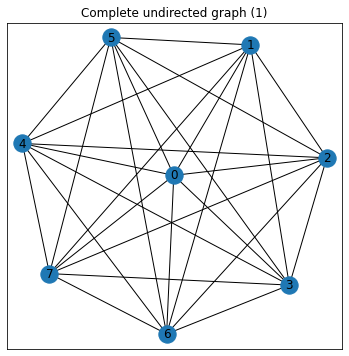

In [112]:
G = complete_graph(nodes) # or nx.complete_graph(nodes)

fig, ax = plt.subplots(figsize=(6, 6))
nx.draw_networkx(G)
plt.title("Complete undirected graph (1)")
plt.show()

## 2. Perform conditional independence tests at a given significance level and delete edges based on the tests <a name="direct"></a>

See all the datails in the PDF

### Threshold
This function finds the threshold:  <a name="threshold"></a> 

In [113]:
def threshold (alpha,n,s):
    if isinstance(s,int):
        #print("s is int")
        abs_s = 1
    else: 
        abs_s = len(s)
    num = norm.ppf(1-alpha/2)
    den = math.sqrt(n-abs_s-3)
    return num/den

### Sample partial correlation

Covariance matrix $\Sigma$ :

In [114]:
cov = np.cov(data.T)
cov.shape

(8, 8)

In [115]:
#check if the covariance matrix is symmetric
(cov.transpose() == cov).all()

True

- This function finds $\Sigma_{X|Y}$ for a multivariate sample and calculate the partial correlation (see PDF): <a name="partial"></a> 

In [116]:
def cond_part_corr_normal (cov,x,y):
    
    # for this algorithm x always has two nodes
    
    if len(x)!=2:
        print("X should contain two nodes")
        return 0

    if not y: # empty
        cond_cov = cov
    else:
        
        #conditional cov
        sigma_x = cov[x][:,x]
        
        if isinstance(y,int): # if y is a int
            sigma_y = cov[y][y]
            sigma_xy = cov[x,y].reshape(2,1)
            sigma_yx = cov[y,x]

            cond_cov = sigma_x - sigma_xy * (np.reciprocal(sigma_y)) * sigma_yx

        else: # if y is a list
            sigma_y = cov[y][:,y]
            inv_sigma_y = inv(sigma_y)
            sigma_xy = cov[x][:,y]
            sigma_yx = cov[y][:,x]
            
            cond_cov = sigma_x - sigma_xy @ inv_sigma_y @ sigma_yx # formula in the pdf
  
    aij = cond_cov[0,1]
    aii = cond_cov[0,0]
    ajj = cond_cov[1,1]

    partial_corr = aij / (math.sqrt(abs(aii*ajj)))

    partial_corr = abs(partial_corr)
    
    partial_corr = 0.5* np.log((1+partial_corr)/(1-partial_corr))

    return partial_corr

- Partial correlation suing **pingouin** (we do not use it): <a name="partialp"></a> 

In [117]:
def part_corr_pingouin (data,a,z):
    
    values = [data[: , a[0]]] # shape 10000x1
    values = np.concatenate((values, [data[: , a[1]]])) 
    values = np.concatenate((values, [data[: , z[0]]])) 
    
    # we have to use these names to make it work
    name = ["x","y",str(z[0])]
    
    if len(z)>1:
        for i in z[1:]:
            values = np.concatenate((values, [data[: , i]])) 
            name =  np.concatenate((name, [str(i)] ))

    df = pd.DataFrame(values.T, columns=name)
 
    result = df.pcorr()

    return abs(result.y.x)

### Remove edges 
In the nex cell we remove edges from the completed undirected graph: <a name="delete"></a>

In [118]:
def undirected_neighbours(G,i):
    # finds all neigbours of i in undirected G
    
    neig = list(G.neighbors(i))
    
    return neig

In [119]:
def completely_connected_directed_graph(G):
    F = nx.DiGraph()
    F.add_edges_from(G.edges())

    #also inverted edges
    for i in G.edges(): 
        F.add_edge(i[1],i[0])
        
    return F

In [122]:
print("Remove edges:")

S = dict.fromkeys(completely_connected_directed_graph(G).edges, []) 
#S[(0,1)]=2


for l in range(num_nodes):
    print (l)
    
    for edge in G.edges:
        i = edge[0]
        j = edge[1]
        
        paths = list(nx.all_simple_paths(G, i,j, cutoff=l))
        print(edge)
        print(paths)
        
        
        
        

Remove edges:
0
(0, 1)
[]
(0, 2)
[]
(0, 3)
[]
(0, 4)
[]
(0, 5)
[]
(0, 6)
[]
(0, 7)
[]
(1, 2)
[]
(1, 3)
[]
(1, 4)
[]
(1, 5)
[]
(1, 6)
[]
(1, 7)
[]
(2, 3)
[]
(2, 4)
[]
(2, 5)
[]
(2, 6)
[]
(2, 7)
[]
(3, 4)
[]
(3, 5)
[]
(3, 6)
[]
(3, 7)
[]
(4, 5)
[]
(4, 6)
[]
(4, 7)
[]
(5, 6)
[]
(5, 7)
[]
(6, 7)
[]
1
(0, 1)
[[0, 1]]
(0, 2)
[[0, 2]]
(0, 3)
[[0, 3]]
(0, 4)
[[0, 4]]
(0, 5)
[[0, 5]]
(0, 6)
[[0, 6]]
(0, 7)
[[0, 7]]
(1, 2)
[[1, 2]]
(1, 3)
[[1, 3]]
(1, 4)
[[1, 4]]
(1, 5)
[[1, 5]]
(1, 6)
[[1, 6]]
(1, 7)
[[1, 7]]
(2, 3)
[[2, 3]]
(2, 4)
[[2, 4]]
(2, 5)
[[2, 5]]
(2, 6)
[[2, 6]]
(2, 7)
[[2, 7]]
(3, 4)
[[3, 4]]
(3, 5)
[[3, 5]]
(3, 6)
[[3, 6]]
(3, 7)
[[3, 7]]
(4, 5)
[[4, 5]]
(4, 6)
[[4, 6]]
(4, 7)
[[4, 7]]
(5, 6)
[[5, 6]]
(5, 7)
[[5, 7]]
(6, 7)
[[6, 7]]
2
(0, 1)
[[0, 1], [0, 2, 1], [0, 3, 1], [0, 4, 1], [0, 5, 1], [0, 6, 1], [0, 7, 1]]
(0, 2)
[[0, 1, 2], [0, 2], [0, 3, 2], [0, 4, 2], [0, 5, 2], [0, 6, 2], [0, 7, 2]]
(0, 3)
[[0, 1, 3], [0, 2, 3], [0, 3], [0, 4, 3], [0, 5, 3], [0, 6, 3], [0, 7, 3]]
(0, 4)

In [104]:
print("Remove edges:")
for i in list(nodes):
    for j in list(nodes):
        if j>i: # no the node itself and no repeat

            # all the nodes which are not i or j:
            nodes = G.nodes()
            s = [x for x in nodes if x!=i]
            other_nodes = [x for x in s if x!=j]

            x = [i,j]
    
            # all the possible combinations of all other nodes:
            combinationss = list( chain(*map(lambda x: combinations(other_nodes, x), range(0, len(other_nodes)+1))))
            combinationss = [x for x in combinationss if len(x)>0]
            combinationss = [np.array(x) for x in combinationss] # if len(x)>0]

            for comb in combinationss:

                # check if i is indipendent from j given s
                partial_corr = cond_part_corr_normal (cov,x,list(comb))
                t = threshold(alpha,n, list(comb))

                if partial_corr<t: # Independence!
                    print("%d - %d : %d ⟂ %d | %s  (part_corr = %.4f threshold = %.4f )" %(i, j, i, j, str(comb), partial_corr, t))
                    G.remove_edge(i,j)
                    break # go to the next edge
                    

Remove edges:
0 - 1 : 0 ⟂ 1 | [2]  (part_corr = 0.0012 threshold = 0.0196 )
0 - 3 : 0 ⟂ 3 | [2]  (part_corr = 0.0151 threshold = 0.0196 )
0 - 5 : 0 ⟂ 5 | [2 4]  (part_corr = 0.0143 threshold = 0.0196 )
0 - 6 : 0 ⟂ 6 | [4]  (part_corr = 0.0066 threshold = 0.0196 )
0 - 7 : 0 ⟂ 7 | [1 2 6]  (part_corr = 0.0152 threshold = 0.0196 )
1 - 2 : 1 ⟂ 2 | [0]  (part_corr = 0.0019 threshold = 0.0196 )
1 - 3 : 1 ⟂ 3 | [0]  (part_corr = 0.0133 threshold = 0.0196 )
1 - 4 : 1 ⟂ 4 | [0]  (part_corr = 0.0042 threshold = 0.0196 )
1 - 5 : 1 ⟂ 5 | [0]  (part_corr = 0.0025 threshold = 0.0196 )
1 - 7 : 1 ⟂ 7 | [0]  (part_corr = 0.0032 threshold = 0.0196 )
2 - 4 : 2 ⟂ 4 | [0 3]  (part_corr = 0.0011 threshold = 0.0196 )
2 - 5 : 2 ⟂ 5 | [4]  (part_corr = 0.0169 threshold = 0.0196 )
2 - 6 : 2 ⟂ 6 | [4]  (part_corr = 0.0032 threshold = 0.0196 )
3 - 5 : 3 ⟂ 5 | [4]  (part_corr = 0.0052 threshold = 0.0196 )
3 - 6 : 3 ⟂ 6 | [0 1 4 7]  (part_corr = 0.0179 threshold = 0.0196 )
5 - 6 : 5 ⟂ 6 | [4]  (part_corr = 0.0003 t

In [105]:
⟂

SyntaxError: invalid character in identifier (<ipython-input-105-f68d3fe0eb82>, line 1)

In [ ]:
# plot undirected graph:

fig, ax = plt.subplots(figsize=(6, 6))

if nx.check_planarity(G, counterexample=False)[0]==True: # if planar
    pos = nx.circular_layout(G)
    nx.draw(G, pos=pos, with_labels=True)
else: # if not planar
    pos = nx.draw_networkx(G)
    
plt.title("Undirected graph after the indipendence test (2)")
plt.show()

In [57]:
undirected_neighbours(G,4)

[0, 3, 5, 6, 7]

### 3. Orient V-structures <a name="orient"></a>

Find unshielded colliders

In [15]:
di_G = nx.DiGraph() # directed graph
di_G.add_nodes_from(G.nodes()) # add all nodes

Find all undirected v structures: <a name="findv"></a>

In [16]:
def find_v_struct(nodes,G):
    triples = list(combinations(nodes,3)) # all possible group of 3 nodes

    v_struct = [] # save all v structures

    for triple in triples:
        permuta = list(permutations(triple))
        for t in permuta:
            if G.has_edge(t[0],t[1]) and G.has_edge(t[2],t[1]) and not G.has_edge(t[0],t[2]): 
                v_struct.append(t)

    # app v structures are in double copy, so I keep only one
    v_struct = np.array([v_struct[v] for v in range(len(v_struct)) if v%2==0])
    
    return v_struct

Function which say if in a v structure ( _i->j>-v_ ) j is a **collider**: <a name="unshielded"></a>

In [17]:
def is_unshielded_collider(G, triple, alpha, n, cov):
    
    i = triple[0]
    j = triple[1]
    v = triple[2]
    
    # check that i and v are not linked (this should be true by constructions, but it is better to check)
    if G.has_edge(i,v)==True: 
        return False # j cannot be a collider
    
    # check that i and v are linked to j this should be true by constructions, but it is better to check)
    if G.has_edge(i,j)==False or G.has_edge(v,j)==False:
        return False # j cannot be a collider
    
    # other nodes apart i,j,v:
    other_nodes = G.nodes -{i,j,v}
    
    # combination of all other nodes:
    combinationss = list( chain(*map(lambda x: combinations(other_nodes, x), range(0, len(other_nodes)+1))))
    
    # len>0???
    
    combinationss = [np.array(x) for x in combinationss] # if len(x)>0]
    combinationss = [x for x in combinationss if len(x)>0]
    
    
    for comb in combinationss:
        
        # check if i is indipendent from j given s
        partial_corr = cond_part_corr_normal (cov,[i,v],list(comb))
        t = threshold(alpha,n, comb)
        
        # we want to find all subsets for which they are ind 
        if partial_corr<t: # zero corr
            # they are indipendent
            
            # we want to see if, adding j we have dependence. 
            # In this case j is a collider. Otherwise we continue to check with other combinations of subsets
            if len(comb)<1: # if comb is the empty set
                comb_with_j = int(j)
            else:
                comb_with_j = list(np.concatenate((comb , [j])))
                
            partial_corr_with_j = cond_part_corr_normal (cov,[i,v],comb_with_j)
            t_with_j = threshold(alpha, n, comb_with_j)
            
            #if they are dependent j is a collider
            if partial_corr_with_j > t_with_j:
                print(f"For the v-struct {i}->{j}<-{v} : {i} ⟂ {v} given {comb} but {i} not ⟂ {v} given {comb_with_j} ")
                #if we arrive to this point at least once, j is a collider
                return True
            
        #else: positive partial corr => they are dependend => not a collider
        
    return False

Delete double headed edges:

def double_headed

**Statistical orientation**:  <a name="stat"></a>
Function to find unshielded colliders and create edges:

In [18]:
def statistical_orientation(nodes,G,di_G,alpha,n,cov):
    v_struct = find_v_struct(nodes,G)

    for v in v_struct:

        v_collider_bool = is_unshielded_collider(G, v, alpha, n, cov)

        #if v[1] is an unshielded collider 
        if v_collider_bool==True :
            di_G.add_edge(v[0],v[1])
            di_G.add_edge(v[2],v[1])
    
    return 

In [19]:
statistical_orientation(nodes,G,di_G,alpha,n,cov)

For the v-struct 0->2<-3 : 0 ⟂ 3 given [1 5 6] but 0 not ⟂ 3 given [1, 5, 6, 2] 
For the v-struct 0->4<-3 : 0 ⟂ 3 given [2] but 0 not ⟂ 3 given [2, 4] 
For the v-struct 0->4<-7 : 0 ⟂ 7 given [1 2 6] but 0 not ⟂ 7 given [1, 2, 6, 4] 
For the v-struct 1->6<-4 : 1 ⟂ 4 given [0] but 1 not ⟂ 4 given [0, 6] 
For the v-struct 2->7<-4 : 2 ⟂ 4 given [0 3] but 2 not ⟂ 4 given [0, 3, 7] 


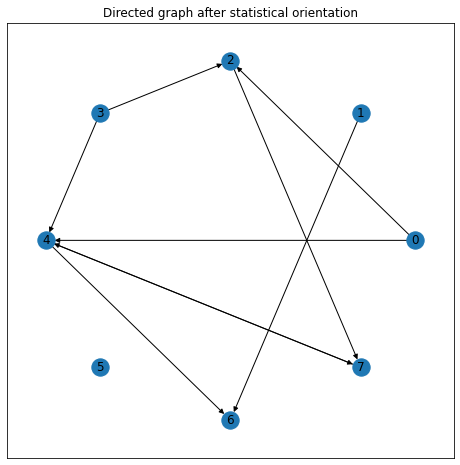

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
#nx.draw_planar(di_G, with_labels=True)
nx.draw_networkx(di_G, pos = pos)
plt.title("Directed graph after statistical orientation")
plt.show()

In [21]:
# cut double directed edges
for edge in G.edges:
    if edge in di_G.edges and (edge[1], edge[0]) in di_G.edges:
        di_G.remove_edge(edge[0], edge[1])
        di_G.remove_edge(edge[1], edge[0])

In [22]:
"""di_G.remove_edge(0,3)
di_G.remove_edge(7,3)
di_G.remove_edge(0,4)
di_G.remove_edge(7,4)"""

'di_G.remove_edge(0,3)\ndi_G.remove_edge(7,3)\ndi_G.remove_edge(0,4)\ndi_G.remove_edge(7,4)'

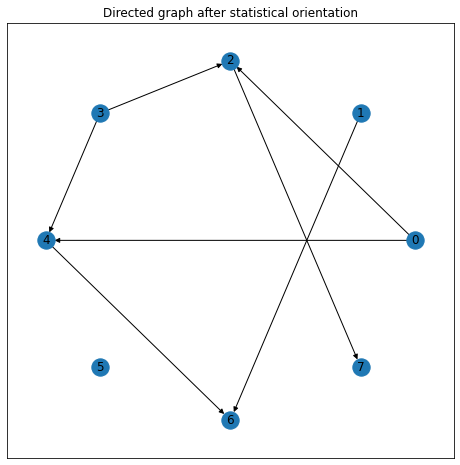

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
#nx.draw_planar(di_G, with_labels=True)
nx.draw_networkx(di_G, pos = pos)
plt.title("Directed graph after statistical orientation")
plt.show()

This function find the colliders (attention: we mean colliders already created in the directed graph)  <a name="findcc"></a>

note: we do not save them directly before when we do the statistical orientation because this function can be useful is different situations

### Rules

Check if the edge a-b is already directed:

In [24]:
def already_directed(a,b,di_G):
    if (a,b) in di_G:
        return True
    if (b,a) in di_G:
        return True
    return False

In [25]:
def meek_rule_1(a,b, G,di_G):
    
    if already_directed(a,b,di_G)==True: # already directed
        return 0
    
    # list of possible c
    neghs_a = list(G.neighbors(a)) # neigbours

    # c if exists c->a
    c_linked_a = [c for c in neghs_a if (c,a) in di_G.edges]
    
    # c cannot be linked to b in G
    c_linked_a = [c for c in c_linked_a if (c,b) not in G.edges]
    c = [c for c in c_linked_a if (b,c) not in G.edges]
    
    # if c is not empty
    if len(c)>0:
        di_G.add_edge(a,b) # add edge
        print(f"Meek1 {a}->{b}: exist {c[0]} such that {c[0]}->{a} and ({c[0]},{b}) not in G")
        return 1
    
    return 0

In [26]:
def meek_rule_2(a,b, G,di_G):

    if already_directed(a,b,di_G)==True: # already directed
        return 0
    
    # list of possible c
    neghs_a = list(G.neighbors(a)) # neigbours
    
    # c if exists a->c
    c_linked_a = [c for c in neghs_a if (a,c) in di_G.edges]
    
    # c if exist c->b
    c = [c for c in c_linked_a if (c,b) in di_G.edges]
    
    # if c is not empty
    if len(c)>0:
        di_G.add_edge(a,b) # add edge
        print(f"Meek2 {a}->{b}: exist {c[0]} such that {a}->{c[0]} and {c[0]}->{b} (avoid cycle)")
        return 1
    
    return 0

In [27]:
def meek_rule_3(a,b, G,di_G):

    if already_directed(a,b,di_G)==True: # already directed
        return 0
    
    # list of possible c or d
    neghs_a = list(G.neighbors(a)) # neigbours
    
    # c(d) if exist c(b)->b
    c_or_d = [c for c in neghs_a if (c,b) in di_G.edges]
    
    flag = 0
    for c in c_or_d:
        
        possible_d = c_or_d.remove(c)
        
        if possible_d is not None:
            # c not linked to d
            d = [d for d in possible_d if (c,d) not in G.edges]

            if len(d)>0: # we have found at least one d
                flag=1
                break

    
    if flag==1:
        di_G.add_edge(a,b) # add edge
        print(f"Meek3 {a}->{b}: exist {c},{d[0]} such that {a}-{c}, {a}-{d[0]}, {c}->{b}, {d[0]}->{b} and ({c},{d[0]}) not in G")
        return 1
    
    return 0

In [28]:
def meek_rule_4(a,b, G,di_G):

    if already_directed(a,b,di_G)==True: # already directed
        return 0
    
    # list of possible c or d
    neghs_a = list(G.neighbors(a)) # neigbours
    
    # c(d) if exist c(b)->b
    c_or_d = [c for c in neghs_a if (c,b) in di_G.edges]
    
    flag = 0
    for c in c_or_d:
        
        # we need c->b
        if (c,b) in di_G.edges:
        
            possible_d = c_or_d.remove(c)
            
            if possible_d is not None:
                # d not linked to b
                possible_d = [ d for d in possible_d if (d,b) in G.edges]

                if possible_d is not None:
                    # d->c
                    d = [d for d in possible_d if (d,c) in di_G.edges]

                    if len(d)>0: # we have found at least one d
                        flag=1
                        break

    
    if flag==1:
        di_G.add_edge(a,b) # add edge
        print(f"Meek4 {a}->{b}: exist {c},{d[0]} such that {a}-{c}, {a}-{d[0]}, {c}->{b}, {d[0]}->{c} and ({b},{d[0]}) not in G")
        return 1
    
    return 0

Function which find all unidrected edges:

In [29]:
def only_undirected_edges(G,di_G):
    
    directed_edges = list(di_G.edges()) # directed
    directed_edges2 = [(e[1],e[0]) for e in directed_edges] # directed other sense
    
    # total directed both direction
    tot_directed = directed_edges + directed_edges2
    
    undirected_edges = [e for e in list(G.edges()) if e not in tot_directed] 
    
    #undirected_edges = set(G.edges()) - set(directed_edges) - set(directed_edges2)
    
    return undirected_edges

In [30]:
only_undirected_edges(G,di_G)

[(3, 7), (4, 5), (4, 7)]

In [31]:
def meek_rules(G,di_G):
    
    flag = 0 

    while flag == 0: # continue till you don't add any other edges
        
        flag = 1 # it will become 1 if we'll add other edges

        # find all undirected nodes
        still_undirected = only_undirected_edges(G,di_G)

        # try to orient all undirect edges
        for edge in still_undirected: 
            a = edge[0]
            b = edge[1]

            meek1 = meek_rule_1(a, b, G ,di_G)
            meek2 = meek_rule_2(a, b, G, di_G)
            meek3 = meek_rule_3(a, b, G, di_G)
            meek4 = meek_rule_4(a, b, G, di_G)

            # if we have added atr least one edge we have to re-check everything
            if meek1==1 or meek2==1 or meek3==1 or meek4==1:
                flag = 0
            
        return

In [32]:
meek_rules(G,di_G)

Meek2 3->7: exist 2 such that 3->2 and 2->7 (avoid cycle)
Meek1 4->5: exist 0 such that 0->4 and (0,5) not in G
Meek1 4->7: exist 0 such that 0->4 and (0,7) not in G


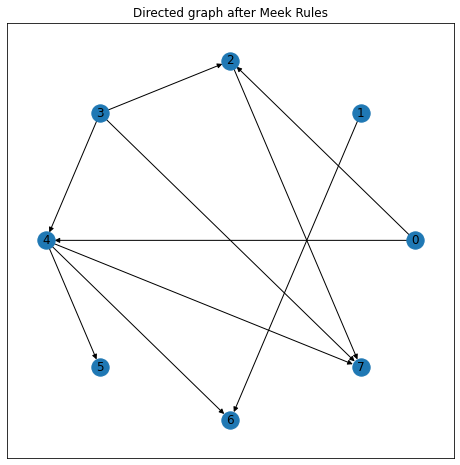

In [33]:
fig, ax = plt.subplots(figsize=(8,8))
nx.draw_networkx(di_G, pos = pos)
plt.title("Directed graph after Meek Rules")
plt.show()

### Avoid cycles <a name="cycle"></a>

Check we have a dag:

In [34]:
def is_dag(di_G):
    try:
        find_cycle(di_G)
    except:
        # print("No cycles (GOOD)")
        return True
   

In [35]:
is_dag(di_G)

True

Find all undirected cycles:
remember that a cycle can also have more the 3 nodes!
First we create a completely directed graph because _simple_cicle_ works only with directed graphs

Function which created a completely connected and completely directed graph:

The following function is useful to gain time when we try to direct edges avoiding cycle. Its goal is to indentify if there are colliders in a subgraph (the cycle), in order to understand if we can be sure that adding new edges will not create a cycle for sure. In this case, if we have _i->j<-v_, we are not interest in understanding if i and v are linked:  <a name="coll"></a>

In [37]:
def find_colliders_also_linked(G, di_G):
    # undirected G
    # directed di_G 

    coll = []

    for edge1 in di_G.edges():
        for edge2 in di_G.edges():
            if edge1 != edge2: # not the same edge
                
                if edge1[1] == edge2[1]: #they arrive to the same node
                    # collider!
                    coll.append(edge1[1])    

    coll = list(dict.fromkeys(coll)) # no duplicates
    return coll

This fuctions has the opposite role of the previous one. It finds all the structures of the type _i<-y->v_. Also in this case it is useful to avoid to try to add edges if we already know that with these structes we will never get a cycle  <a name="tails"></a>

In [38]:
def find_tails(G, di_G):
    # undirected G
    # directed di_G 

    tails = []

    for edge1 in di_G.edges():
        for edge2 in di_G.edges():
            if edge1 != edge2: # not the same edge
                
                if edge1[0] == edge2[0]: #they arrive to the same node
                    # collider!
                    tails.append(edge1[1])    

    tails = list(dict.fromkeys(tails)) # no duplicates
    return tails

This function finds all the cycles in a directed graph F: <a name="dircycle"></a>

In [39]:
def find_cycles(G):
    
    F = completely_connected_directed_graph(G)
    
    # all cycles 
    cycles = list(simple_cycles(F))

    # don't consider cycles with only two nodesù
    cycles = [c for c in cycles if len(c)>2]
 
    # drop duclicates for cycles with 3 nodes    
    c3 = []
    cc = []
    for c in cycles:
        if len(c)==3:
            c3.append(c)
        else: # more than 3 nodes
            cc.append(c)
            
    c3 = [sorted(c) for c in c3]    
    c3.sort()
    c3 = list(c3 for c3,_ in itertools.groupby(c3))

    cycles = c3 + cc
    
    return cycles

In [40]:
find_cycles(G)

[[2, 3, 7],
 [3, 4, 7],
 [0, 4, 3, 2],
 [0, 4, 3, 7, 2],
 [0, 4, 7, 3, 2],
 [0, 4, 7, 2],
 [0, 2, 7, 4],
 [0, 2, 7, 3, 4],
 [0, 2, 3, 7, 4],
 [0, 2, 3, 4],
 [2, 7, 4, 3],
 [2, 3, 4, 7]]

This function try to add an edge in a cycle in the right direction.  <a name="checkcycle"></a>

Parameters:

    - di_G: directed 
    - cycle_graph: graph of the cycle
    - nodes : nodes between which check if we can add an edge
    
Result: nodes in order of direction or 0 if we cannot add them

In [41]:
def check_add_edge_cycle(di_G, cycle_graph, nodes):
    
    # we try in one direction
    cycle_graph.add_edge(nodes[0], nodes[1])
    
    # now I have to check if I have a cycle
    if len(list(simple_cycles(cycle_graph)))==0: # no cycles

        # we add it only if we would have had obtained a cycle in the other direction
        cycle_graph.remove_edge(nodes[0], nodes[1]) # remove the edge
        cycle_graph.add_edge(nodes[1], nodes[0]) # add the edge in the other direction

        if len(list(simple_cycles(cycle_graph)))>0 and di_G.has_edge(nodes[0], nodes[1])==False: 
            # the other direction would have given a cycle
            return [nodes[0], nodes[1]]
        
    else: # we have a cycle: try with an edge in the other direction
        
        cycle_graph.remove_edge(nodes[0], nodes[1]) # remove the edge
        cycle_graph.add_edge(nodes[1], nodes[0]) # add the edge in the other direction

        if len(list(simple_cycles(cycle_graph)))==0 and di_G.has_edge(nodes[1], nodes[0])==False: # no cycles
             return [nodes[1], nodes[0]]
            
    return 0

Main part for the cycle part: create edges avoiding cycles  <a name="mamma"></a>

In [42]:
def avoid_cycles(G, di_G):
    
    nodes = list(G.nodes)
    
    #check if we have a dag
    is_dag(di_G)

    cycles = find_cycles(G) # calculate only once because the cycles of teh undirected graph (or completely directed) do not change 

    flag = 0 

    while flag == 0: # continue till you don't add any other edges

        flag = 1 # it will become 1 if we'll add other edges

        # we use the all possible cycles of the graph, so we can always use cycles
        for cycle in cycles:


            #draw a directed graph for that cycle
            cycle_graph = nx.DiGraph()

            # Now we separate 2 cases: cycles with 3 edges and with more than 3 edges

            if len(cycle)==3:

                #check if some edges are already present
                for (i, j) in combinations(cycle, 2):
                    if di_G.has_edge(i,j) :
                        cycle_graph.add_edge(i,j)
                    if di_G.has_edge(j,i) :
                        cycle_graph.add_edge(j,i)

                un_cycle_graph = complete_graph(cycle) # undirected complete graph of the cycle

                # colliders and tails:
                coll = find_colliders_also_linked(un_cycle_graph, cycle_graph)
                tails = find_tails(un_cycle_graph, cycle_graph)

                # if there are colliders we do not risk to create a cycle, so we don't add anything
                # otherwise:
                if not coll and not tails:


                    # if we miss more than one edge for each cycle, we surely don't risk to create a cycle in this step
                    # we consider only when we miss one edge

                    if len(cycle_graph.edges)==len(cycle)-1: 

                        # we try to add a directional edge and we check if we would get a cycle. if we would 
                        # we had the edge in the inverse direction

                        #for each node we save the number of neigh and we create an edge between the two nodes with less edges
                        neigh = [cycle_graph.degree(node) for node in cycle]

                        #create an edge between the two mins:
                        minn = min(neigh) # find the min
                        poss = [i for i, e in enumerate(neigh) if e == minn] # find the positions of the min

                        nodemin = [cycle[poss[0]], cycle[poss[1]]] # nodes with min
                        
                        new_edge = check_add_edge_cycle(di_G, cycle_graph, nodemin)
                        
                        if new_edge!=0: # if we can add an edge
                                
                            di_G.add_edge(new_edge[0], new_edge[1])

                            print(f"Cycle {cycle}:")
                            print(f"Add edge: {new_edge[0]} -> {new_edge[1]} \n")

                            flag = 0

            else: #cycles with more than 3 edges

                # in this case we have to pay attention because we want only to consider external cycles. if there are internal cycles we don't
                # discuss them (they are other cases). See PDF for more details

                # the order of nodes in cycle indicates the only way in ehich we can have edges
                cycle_plus = cycle + [cycle[0]]

                for i in range(len(cycle)):
                    if di_G.has_edge(cycle_plus[i], cycle_plus[i+1]):
                        cycle_graph.add_edge(cycle_plus[i], cycle_plus[i+1])

                    elif di_G.has_edge(cycle_plus[i+1], cycle_plus[i]):
                        cycle_graph.add_edge(cycle_plus[i+1], cycle_plus[i])

                    else: # not directed edge (we save only one because if it is more than one we cannot add more edges in one passage)
                        missing_edge = [cycle_plus[i], cycle_plus[i+1]]


                if len(cycle_graph.edges)==len(cycle)-1: # only one missed ( missing_edge )
                    
                    new_edge = check_add_edge_cycle(di_G, cycle_graph, missing_edge)

                    if new_edge!=0: # if we can add an edge
                        
                        di_G.add_edge(new_edge[0], new_edge[1])

                        print(f"Cycle {cycle}:")
                        print(f"Add edge: {new_edge[0]} -> {new_edge[1]} \n")
                        flag = 0

    is_dag(di_G)
    
    return 

In [43]:
avoid_cycles(G, di_G)

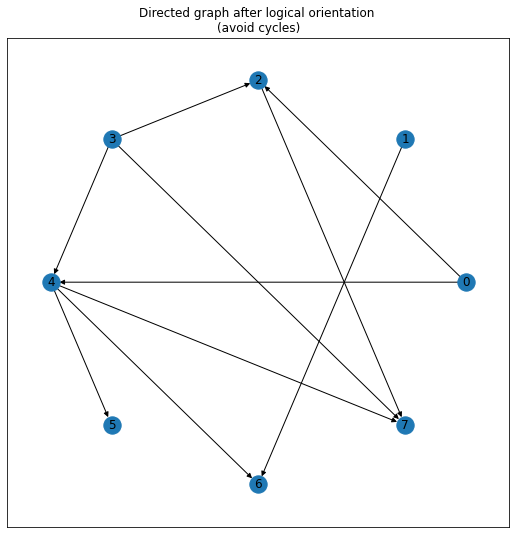

In [44]:
fig, ax = plt.subplots(figsize=(9, 9))
nx.draw_networkx(di_G, pos = pos)
plt.title("Directed graph after logical orientation \n(avoid cycles)")
plt.show()

In [45]:
#di_G.remove_edge(6,4)
#di_G.remove_edge(5,6)

#G.add_edge(5,8)
#G.add_edge(9,8)

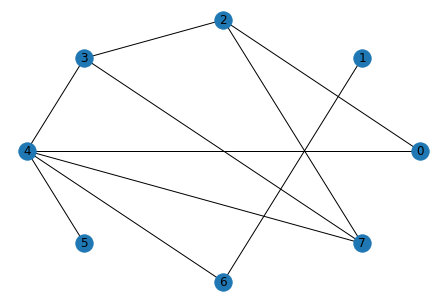

In [46]:
nx.draw(G, pos=pos, with_labels=True)

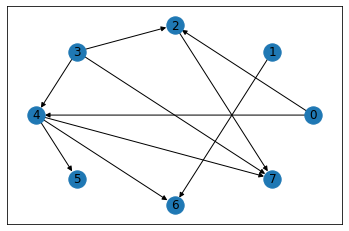

In [47]:
nx.draw_networkx(di_G, pos = pos)

### Equivalence classes <a name="equivalence"></a>

Firstly, we find all the undirected edges. They are the edges which are in G and not in di_G

In [48]:
def undirected_edges(G,di_G):
    edges_G = G.edges
    edges_di_G = di_G.edges
    
    #print(edges_G)
    #print(edges_di_G)
    
    undirected = [x for x in edges_G if x not in edges_di_G ] # remove edges directed in one directed
    undirected = [x for x in undirected if reversed(x) not in edges_di_G ] # or in the other direction
    
    return undirected

In [49]:
undirected_edges(G,di_G)

[]

In [50]:
len(undirected_edges(G,di_G))

0

At this point we can think that, for each undirected edge we have two opportunity (one direction and the other). So if we have $n$ undirected edges, one can think that $2^n$ is the answer.

However, if we have more than one undirected edge, if we direct one, this can direct also the others. For example, if we have two undirected edges, it can happen that if we direct one, the other one has to be directed in order to avoid cycles.

This function return how many DAGs are in the corresponding equivalence class 

In [51]:
def equivalence_classes(equi_classes, G, di_G):
    
    undirected = undirected_edges(G,di_G)
    
    if len(undirected)==0: # all already directed
        print("All edges are already directed")
        print(di_G)
        return [di_G]

    
    equi_classes = []
    
    print(f"\n--------------------------\nUnidrected edge: {undirected}\n")
    
    if len(undirected)==1: # only one undirected edge
        
        print("only one undirected edge")
        
        # we are sure not to create unshielded colliders or cycles, otherwise we would have detected it before
        
        #return 2
        G1 = nx.DiGraph()
        G2 = nx.DiGraph()
        
        G1.add_edges_from(di_G.edges)
        G2.add_edges_from(di_G.edges)
        
        G1.add_edge(undirected[0][0],undirected[0][1])
        G2.add_edge(undirected[0][1],undirected[0][0])
        
        equi_classes.append(G1)
        equi_classes.append(G2)
        
        return equi_classes
        
    elif len(undirected)>1: # more than one
        
        # num_equi = 0 # number of equivalent classes
        equi_classes = []
        
        # equivalent graph
        equivalent_G = nx.DiGraph()
        equivalent_G.add_edges_from(di_G.edges) # add all edges from gi_G
        
        #### we try to add one edge in one direction
        
        added_edge = undirected[0]
        print(f"ADD EDGE: {added_edge}")
        
        equivalent_G.add_edge(added_edge[0], added_edge[1])
        
        # now we check if other edges are still undirected or if we can direct some:
        
        print("\nAVOID UNSHIELDED COLLIDERS:")
        logical_orientation(G, equivalent_G)
        
        print("\nAVOID CYCLES:")
        avoid_cycles(G, equivalent_G)

        # at this point we can have all directed, or no new directed, or some of them directed
        
        if not undirected_edges(G,equivalent_G) and is_dag(equivalent_G) == True: # all directed and it is a DAG
            print("\nAll directed \n")
 
            # we added one edge and this directed all the others. we add this final configuration
            equi_classes.append(equivalent_G)
            
        elif is_dag(equivalent_G) == True: # some not directed but it is a DAG
            # recall the function
            new = equivalence_classes(equi_classes,G,equivalent_G)
       
            for graph in new:
                equi_classes.append(graph)
            
            
        #else: it is not a DAG and therefore this edge cannot be added

        #### we try to add one edge in the other direction

        equivalent_G1 = nx.DiGraph()
        equivalent_G1.add_edges_from(di_G.edges) # add all edges from gi_G
        added_edge = (undirected[0][1], undirected[0][0])
        
        print(f"\n\nADD EDGE: {added_edge}")
        
        equivalent_G1.add_edge(added_edge[0], added_edge[1])
        
        # now we check if other edges are still undirected or if we can direct some:
        
        print("\nAVOID UNSHIELDED COLLIDERS:")
        logical_orientation(G,equivalent_G1)
        
        print("\nAVOID CYCLES:")
        avoid_cycles(G, equivalent_G1)

        if not undirected_edges(G,equivalent_G1) and is_dag(equivalent_G1) == True: # all directed and it is a DAG
            print("\nAll directed")
            # we added one edge and this directed all the others. we add this final configuration
            equi_classes.append(equivalent_G1)
            
        elif is_dag(equivalent_G1) == True: # some not directed but it is a DAG
            # recall the function
            new = equivalence_classes(equi_classes,G,equivalent_G1)

            for graph in new:
                equi_classes.append(graph)
            
         #else: it is not a DAG and therefore this edge cannot be added
        
    # drop duplicates
    if len(equi_classes)==1: # no duplicates
        return equi_classes
    
    
    equi_classes_unique = []
    for G1 in equi_classes:
        for G2 in equi_classes:

            if nx.is_isomorphic(G1,G2): #equal
                equi_classes_unique.append(G2)
                equi_classes = [x if x is not G2 else nx.DiGraph() for x in equi_classes] # substitude all the other occurence in order not having more      
                break

    return equi_classes_unique

In [52]:
equi_classes = []
equi_classes = equivalence_classes(equi_classes, G, di_G)
equi_classes
len(equi_classes)

All edges are already directed



1

In [53]:
def num_equivalence_class(G,di_G):
    
    equi_classes = []
    equi_classes = equivalence_classes(equi_classes, G, di_G)
    
    if len(equi_classes)==1: # no duplicates
        return 1
    
    return len(equi_classes)

In [54]:
num_equiv_class = num_equivalence_class(G,di_G)

All edges are already directed



We have found the number of equivalent classes

In [55]:
num_equiv_class

1